In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from tensorflow.contrib.factorization.python.ops import factorization_ops
import logging
np.set_printoptions(suppress=True)

In [3]:
logger = logging.getLogger('tensorflow')
logger.setLevel(logging.DEBUG)

In [14]:
transaction = pd.read_csv("data/transaction.csv", names = ['SalesID', 'SalesPersonID', 'CustomerID'
                                                           , 'ProductID', 'Quantity','Discount', 'TotalPrice'
                                                           , 'SalesDate', 'TransactionNumber'], header = 0)
transaction.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber
0,1,6,27039,381,7,NaN,"0,00",2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G
1,2,16,25011,61,7,NaN,"0,00",2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8
2,3,13,94024,23,24,NaN,"0,00",2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0
3,4,8,73966,176,19,0.2,"0,00",2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE
4,5,10,32653,310,9,NaN,"0,00",2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3


In [15]:
# Initially, just treat a purchase as a binray problem'
customer_product = transaction[['CustomerID','ProductID']]
customer_product.head()

,CustomerID,ProductID
0,27039,381
1,25011,61
2,94024,23
3,73966,176
4,32653,310


In [18]:
customer_product.min()

CustomerID    1
ProductID     1
dtype: int64

In [67]:
cp_zero = customer_product.apply(lambda x: x - 1)
cp_zero.min()

CustomerID    0
ProductID     0
dtype: int64

In [68]:
cp_zero['rating'] = 1
cp_zero

,CustomerID,ProductID,rating
0,27038,380,1
1,25010,60,1
2,94023,22,1
3,73965,175,1
4,32652,309,1
5,28662,412,1
6,46673,369,1
7,12686,286,1
8,89008,123,1
9,65016,345,1


In [69]:
# Let's make a massive assumption that if a customer buys items multiple times, they must like it
# So we can use this as a proxy for a 'rating' that this person would give. 

# Obviously, this doesn't have to be the case.

cp_unique = cp_zero.groupby(['CustomerID','ProductID']).sum().reset_index()
cp_unique.head()

,CustomerID,ProductID,rating
0,0,6,1
1,0,124,1
2,0,211,1
3,0,213,1
4,0,252,1


In [70]:
cp_unique['rating'].max()
# Looks like only a few people came back and bought the same product. X_X

3

In [71]:
cp_unique[cp_unique['rating'] == 3]

,CustomerID,ProductID,rating
3036,309,235,3
14452,1437,67,3
25177,2523,139,3
29761,2978,159,3
31685,3172,291,3
36220,3608,273,3
53961,5363,38,3
79863,7974,11,3
86718,8643,317,3
108126,10802,315,3


In [72]:
# Normalise the rating to be between 0 - 1 
cp_unique['rating'] = np.round(cp_unique['rating'] / 3, 2)
cp_unique['rating'].unique()

array([0.33, 0.67, 1.  ])

In [73]:
# Making the dataset

max(np.diff(sorted(cp_unique['ProductID'].unique())))
max(np.diff(sorted(cp_unique['CustomerID'].unique())))

1

In [74]:
# Get the number of products and the number of customers.
NPRODS = cp_unique['ProductID'].unique().shape[0]
NCUSTS = cp_unique['CustomerID'].unique().shape[0]

print(NPRODS, NCUSTS)

452 98759


In [75]:
cp_unique.shape

(989036, 3)

In [76]:
print("{0} products, {1} users, {2} interractions".format(NPRODS, NCUSTS, cp_unique.shape[0]))

452 products, 98759 users, 989036 interractions


In [109]:
grouped_by_products = cp_unique.groupby('ProductID')
i = 0
for product, grouped in grouped_by_products:
    if grouped['CustomerID'].values.__len__() < 2:
        print (product , grouped['CustomerID'].values, grouped['rating'].values)
        break
#     i += 1
#     if i > 5:
#         break

In [112]:
grouped_by_customers = cp_unique.groupby('CustomerID')
i = 0
for customer, grouped in grouped_by_products:
    if grouped['ProductID'].values.__len__() < 2:
        print (customer , grouped['ProductID'].values, grouped['rating'].values)
        break
#     i += 1
#     if i > 5:
#         break

In [83]:
# Map the customers for product and product for customers and build TF records

grouped_by_products = cp_unique.groupby('ProductID')
with tf.python_io.TFRecordWriter('data/customers_for_product') as ofp:
    for product, grouped in grouped_by_products:
        example = tf.train.Example(features= tf.train.Features(
        feature = {
            'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[product])),
            'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['CustomerID'].values)),
            'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
        }
        ))
        ofp.write(example.SerializeToString())

In [84]:
grouped_by_customers = cp_unique.groupby('CustomerID')
with tf.python_io.TFRecordWriter('data/products_for_customer') as ofp:
    for customer, grouped in grouped_by_customers:
        example = tf.train.Example(features= tf.train.Features(
        feature = {
            'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[customer])),
            'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['ProductID'].values)),
            'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
        }
        ))
        ofp.write(example.SerializeToString())

In [85]:
!ls -lrth data

total 115M
-rwxr-xr-x 1 root root  89M Feb 12 05:30 transaction.csv
-rwxr-xr-x 1 root root 1.9K Feb 12 05:30 staff.csv
-rwxr-xr-x 1 root root  181 Feb 12 05:30 product_category.csv
-rwxr-xr-x 1 root root  40K Feb 12 05:30 product.csv
-rwxr-xr-x 1 root root 4.9M Feb 12 05:30 customer.csv
-rwxr-xr-x 1 root root 3.8K Feb 12 05:30 country.csv
-rwxr-xr-x 1 root root 2.7K Feb 12 05:30 city.csv
-rw-r----- 1 root root 1.9M Feb 14 05:42 u.data
-rw-r--r-- 1 root root 6.5M Feb 16 01:04 customers_for_product
-rw-r--r-- 1 root root  12M Feb 16 01:09 products_for_customer


In [86]:
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
import os

In [93]:
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        features = {'key': tf.FixedLenFeature([1], tf.int64),
                    'indices': tf.VarLenFeature(dtype=tf.int64),
                    'values': tf.VarLenFeature(dtype=tf.float32)}
        parsed_features = tf.parse_single_example(protos, features)
        values = tf.sparse_merge(parsed_features['indices'], parsed_features['values'], vocab_size = vocab_size)
        # Remap keys within batch
        key = parsed_features['key']
        decoded_sparse_tensor = tf.SparseTensor(indices=tf.concat([values.indices, [key]], axis = 0),
                                                values = tf.concat([values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return decoded_sparse_tensor
    
    def remap_keys(sparse_tensor):
        bad_indices = sparse_tensor.indices
        bad_values = sparse_tensor.values
        
        # Group by the batch_indices and get the count for each
        size = tf.segment_sum(data = tf.ones_like(bad_indices[:,0], dtype = tf.int64), segment_ids = bad_indices[:,0]) - 1
        
        # The number of batch_indices (batch_size unless partially full)
        length = tf.shape(size, out_type = tf.int64)[0]
        
        # Finds the cumalitive sum which we can use for indexing later
        cs = tf.cumsum(size)
        
        # The offsets between each example in the batch do to concatenation of the keys in the decode_example method
        length_range = tf.range(start = 0, limit = length, delta = 1, dtype = tf.int64)
        
        # Indices of the SparseTensor's indices member of the rows we added by the concatentation of our keys in the decode_example method
        cs_range = cs + length_range
        
        # The keys that we have extracted back out of our concatentated SparseTensor
        gathered_indices = tf.squeeze(tf.gather(bad_indices, cs_range)[:, 1])
        
        # The enumerated row indices of the SparseTensor's indices member
        sparse_indices_range = tf.range(tf.shape(bad_indices, out_type = tf.int64)[0], dtype = tf.int64)
        
        # We want to find here the row indices of the SparseTensor's indices member that are of our actual data and not the concatentated rows
        # So we want to find the intersection of the two sets and then take the opposite of that
        x = sparse_indices_range
        s = cs_range
        
        # Number of multiples we are going to tile x, which is our sparse_indices_range
        tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int64), tf.shape(s, out_type = tf.int64)], axis = 0)
        
        # Expands x, our sparse_indices_range, into a rank 2 tensor and then multiplies the rows by 1 (no copying) and the columns by the number of examples in the batch
        x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
        
        # Essentially a vectorized logical or, that we then negate
        x_not_in_s = ~tf.reduce_any(tf.equal(x_tile, s), -1)
        
        # The SparseTensor's indices that are our actual data by using the boolean_mask we just made above applied to the entire indices member of our SparseTensor
        selected_indices = tf.boolean_mask(tensor = bad_indices, mask = x_not_in_s, axis = 0)
        
        # Apply the same boolean_mask to the entire values member of our SparseTensor to get the actual values data
        selected_values = tf.boolean_mask(tensor = bad_values, mask = x_not_in_s, axis = 0)
        
        # Need to replace the first column of our selected_indices with keys, so we first need to tile our gathered_indices
        tiling = tf.tile(input = tf.expand_dims(gathered_indices[0], -1), multiples = tf.expand_dims(size[0] , -1))
        
        # We have to repeatedly apply the tiling to each example in the batch
        # Since it is jagged we cannot use tf.map_fn due to the stacking of the TensorArray, so we have to create our own custom version
        def loop_body(i, tensor_grow):
              return i + 1, tf.concat(values = [tensor_grow, tf.tile(input = tf.expand_dims(gathered_indices[i], -1), multiples = tf.expand_dims(size[i] , -1))], axis = 0)
            
        _, result = tf.while_loop(lambda i, tensor_grow: i < length, loop_body, [tf.constant(1, dtype = tf.int64), tiling])
        
        # Concatenate tiled keys with the 2nd column of selected_indices
        selected_indices_fixed = tf.concat([tf.expand_dims(result, -1), tf.expand_dims(selected_indices[:, 1], -1)], axis = 1)
        
        # Combine everything together back into a SparseTensor
        remapped_sparse_tensor = tf.SparseTensor(indices = selected_indices_fixed, values = selected_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor
    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(os.path.join(args['input_path'], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(args['batch_size'])
        dataset = dataset.map(lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
    
    def _input_fn():
        features = {
          WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('products_for_customer', args['nprods']),
          WALSMatrixFactorization.INPUT_COLS: parse_tfrecords('customers_for_product', args['ncusts']),
          WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None
    
    return _input_fn

In [94]:
# Quick try out

def try_out():
      with tf.Session() as sess:
        fn = read_dataset(tf.estimator.ModeKeys.EVAL, 
                        {'input_path': 'data', 'batch_size': 4, 'nprods': NPRODS, 'ncusts': NCUSTS})
        feats, _ = fn()
        print(feats['input_rows'].eval())
        print(feats['input_rows'].eval())

try_out()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
SparseTensorValue(indices=array([[  0,   6],
       [  0, 124],
       [  0, 211],
       [  0, 213],
       [  0, 252],
       [  0, 277],
       [  0, 319],
       [  0, 412],
       [  0, 414],
       [  0, 417],
       [  0, 420],
       [  0, 446],
       [  1, 141],
       [  1, 175],
       [  1, 200],
       [  1, 233],
       [  1, 304],
       [  1, 340],
       [  1, 342],
       [  1, 376],
       [  1, 381],
       [  1, 443],
       [  2,  13],
       [  2,  92],
       [  2, 123],
       [  2, 124],
       [  2, 137],
       [  2, 162],
       [  2, 203],
       [  2, 204],
       [  2, 217],
       [  2, 304],
       [  2, 394],
       [  2, 434],
     

In [95]:
def find_top_k(user, item_factors, k):
      all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
      topk = tf.nn.top_k(all_items, k=k)
      return tf.cast(topk.indices, dtype=tf.int64)

In [99]:
def batch_predict(args):
      import numpy as np
      with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
                             num_rows=args['ncusts'], num_cols=args['nprods'],
                             embedding_dimension=args['n_embeds'],
                             model_dir=args['output_dir'])
        # this is how you would get the row factors for out-of-vocab user data
        #row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        #user_factors = tf.convert_to_tensor(np.array(row_factors))

        # but for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
        # in either case, we have to assume catalog doesn't change, so col_factors are read in
        item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)

        # for each user, find the top K items
        topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
        with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
          for best_items_for_user in topk.eval():
            f.write(','.join(str(x) for x in best_items_for_user) + '\n')

In [100]:
def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args['num_epochs'] * args['ncusts']) / args['batch_size'])
    steps_in_epoch = int(0.5 + args['ncusts'] / args['batch_size'])
    print('Will train for {} steps, evaluating once every {} steps'.format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['ncusts'], num_cols=args['nprods'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir']),
            train_input_fn=read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps=train_steps,
            eval_steps=1,
            min_eval_frequency=steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn, args['output_dir'])
    
    batch_predict(args)

In [113]:
import shutil
shutil.rmtree('wals_trained', ignore_errors=True)

train_and_evaluate({
    'output_dir': 'wals_trained',
    'input_path': 'data/',
    'num_epochs': 1,
    'nprods': NPRODS,
    'ncusts': NCUSTS,

    'batch_size': 4,
    'n_embeds': 10,
    'topk': 3
  })

Will train for 24690 steps, evaluating once every 24690 steps
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e0c62ed68>, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_task_id': 0, '_model_dir': 'wals_trained', '_session_config': None, '_environment': 'local', '_task_type': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_device_fn': None, '_evaluation_master': '', '_is_chief': True, '_tf_random_seed': None, '_eval_distribute': None}
DEBUG:tensorflow:Setting feature info to {'input_cols': TensorSignature(dtype=tf.float32, shape=None, is_sparse=True), 'project_row': TensorSignature(dtype=tf.bool, shape=

INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.


In [114]:
# Get row and columns factors

def get_factors(args):
      with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
                             num_rows=args['ncusts'], num_cols=args['nprods'],
                             embedding_dimension=args['n_embeds'],
                             model_dir=args['output_dir'])
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
        return row_factors, col_factors

In [115]:
args = {
    'output_dir': 'wals_trained/',
    'nprods': NPRODS,
    'ncusts': NCUSTS,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7df6224160>, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_task_id': 0, '_model_dir': 'wals_trained/', '_session_config': None, '_environment': 'local', '_task_type': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_device_fn': None, '_evaluation_master': '', '_is_chief': True, '_tf_random_seed': None, '_eval_distribute': None}
[[ 0.01676307 -0.02814763  0.02363351  0.0136393   0.02146445  0.0255074
   0.00058988  0.01134331 -0.02373663  0.02497985]
 [ 0.02221719  0.02169993 -0.0182865   0.00521819  0.02587117 -0.0005646
  -0.00708401 -0.02963769  0.007699

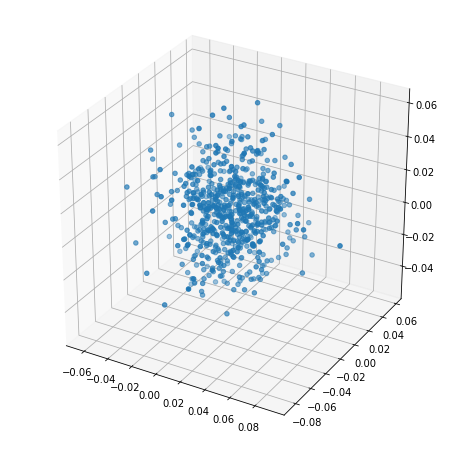

In [118]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)
plt.show()

In [120]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [122]:
trace  = go.Scatter3d(
x = xs,y= ys, z = zs,mode = 'markers')
data = [trace]

fig = go.Figure(data=data)
iplot(fig)